In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder # <--- IMPORT OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Assume 'df' is your DataFrame loaded from a CSV
df = pd.read_csv('Merged_All.csv')

# 1. Define Features (X) and Target (y)
X = df.drop('Label', axis=1)
y = df['Label']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [4]:
# 2. Identify feature types
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Protocol Type'] # This is our target for one-hot encoding

In [5]:
# 3. Create Preprocessing Pipelines
# Pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#
# >>>>>>>>>> START: CORRECTED CODE SECTION <<<<<<<<<<
#
# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle potential missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Convert categories to numbers
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features) # <--- ADDED the categorical transformer
    ],
    remainder='passthrough'
)
#
# >>>>>>>>>> END: CORRECTED CODE SECTION <<<<<<<<<<

In [6]:

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.info()

import numpy as np
# Replace infinite values in training and testing sets with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2863687 entries, 3025411 to 2005773
Data columns (total 39 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    int64  
 2   Time_To_Live     float64
 3   Rate             float64
 4   fin_flag_number  float64
 5   syn_flag_number  float64
 6   rst_flag_number  float64
 7   psh_flag_number  float64
 8   ack_flag_number  float64
 9   ece_flag_number  float64
 10  cwr_flag_number  float64
 11  ack_count        int64  
 12  syn_count        int64  
 13  fin_count        int64  
 14  rst_count        int64  
 15  HTTP             float64
 16  HTTPS            float64
 17  DNS              float64
 18  Telnet           float64
 19  SMTP             float64
 20  SSH              float64
 21  IRC              float64
 22  TCP              float64
 23  UDP              float64
 24  DHCP             float64
 25  ARP              float64
 26  ICMP             float64
 27  IGMP       

In [7]:
# 5. Define and Train the Model using a Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

D:\VIT_HACKATHON\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
import joblib

# Assume 'model_pipeline' is your trained model from the previous steps
# model_pipeline.fit(X_train, y_train)

# Define a filename for your model
filename = 'network_intrusion_model.joblib'

# Save the model to the file
joblib.dump(model_pipeline, filename)

print(f"✅ Model saved successfully to {filename}")

✅ Model saved successfully to network_intrusion_model.joblib


In [9]:
filename = 'network_intrusion_model.joblib'

# Load the model from the file
loaded_model = joblib.load(filename)

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [10]:
# Assume X_test is your test data or new, unseen data
# The loaded model will automatically apply the same preprocessing steps

predictions = loaded_model.predict(X_test)

# You can also get probability estimates
probabilities = loaded_model.predict_proba(X_test)

print("Sample predictions made with the loaded model:")
print(predictions[:5])

Sample predictions made with the loaded model:
[13 25 12  6  9]


In [11]:
# Make predictions on the test set
predictions_numeric = loaded_model.predict(X_test)

# Convert numerical predictions and y_test back to original text labels
predicted_labels = le.inverse_transform(predictions_numeric)
actual_labels = le.inverse_transform(y_test)

# Create a DataFrame for a clear comparison
comparison_df = pd.DataFrame({
    'Actual Label': actual_labels,
    'Predicted Label': predicted_labels
})

# Display the first 10 results
print("Comparison of Actual vs. Predicted Labels:")
print(comparison_df.head(10))

Comparison of Actual vs. Predicted Labels:
              Actual Label          Predicted Label
0           DDOS-TCP_FLOOD           DDOS-TCP_FLOOD
1         MITM-ARPSPOOFING         MITM-ARPSPOOFING
2           DDOS-SYN_FLOOD           DDOS-SYN_FLOOD
3          DDOS-ICMP_FLOOD          DDOS-ICMP_FLOOD
4         DDOS-RSTFINFLOOD         DDOS-RSTFINFLOOD
5  DDOS-SYNONYMOUSIP_FLOOD  DDOS-SYNONYMOUSIP_FLOOD
6          DDOS-ICMP_FLOOD          DDOS-ICMP_FLOOD
7          DDOS-ICMP_FLOOD          DDOS-ICMP_FLOOD
8           DDOS-UDP_FLOOD           DDOS-UDP_FLOOD
9            DOS-TCP_FLOOD           DDOS-TCP_FLOOD



Overall Accuracy: 0.7878

Classification Report:
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.75      0.06      0.12        47
                 BENIGN       0.79      0.92      0.85     16793
       BROWSERHIJACKING       0.74      0.16      0.27        86
       COMMANDINJECTION       0.75      0.23      0.35        79
 DDOS-ACK_FRAGMENTATION       0.99      0.99      0.99      4375
        DDOS-HTTP_FLOOD       0.83      0.71      0.77       446
        DDOS-ICMP_FLOOD       1.00      1.00      1.00    109520
DDOS-ICMP_FRAGMENTATION       0.99      0.99      0.99      6899
      DDOS-PSHACK_FLOOD       1.00      1.00      1.00     62413
       DDOS-RSTFINFLOOD       1.00      1.00      1.00     61582
         DDOS-SLOWLORIS       0.80      0.85      0.82       351
DDOS-SYNONYMOUSIP_FLOOD       0.46      0.74      0.57     54870
         DDOS-SYN_FLOOD       0.53      0.41      0.46     61926
         DDOS-TCP_FLOOD       0.69     

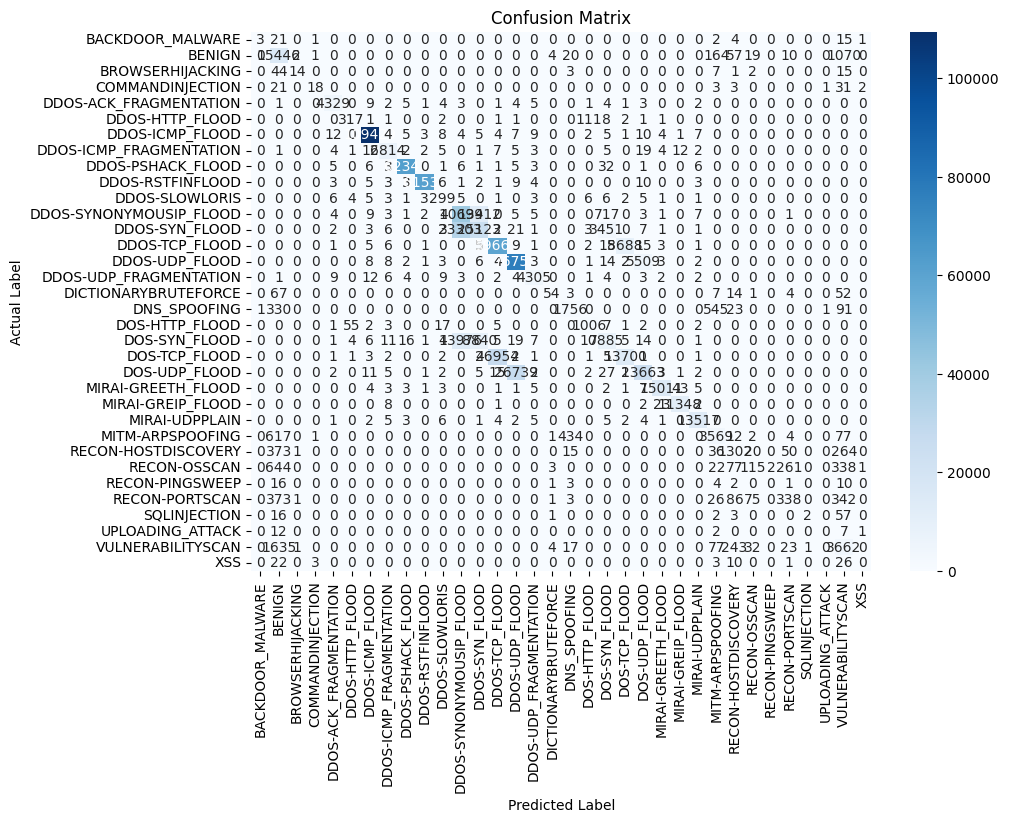

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use the numeric predictions (predictions_numeric) and y_test for metrics
# 1. Calculate and print the overall accuracy
accuracy = accuracy_score(y_test, predictions_numeric)
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# 2. Print the detailed classification report
print("Classification Report:")
print(classification_report(y_test, predictions_numeric, target_names=le.classes_))

# 3. Display the confusion matrix for a visual breakdown
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, predictions_numeric)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()